<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/Training_ALIGNN_model_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of contents

1. Installing [ALIGNN](https://github.com/usnistgov/alignn)
2. Example training for regression on 50 materials,
3. Using already trained models to make fast predictions
4. Training [JARVIS-DFT](https://jarvis.nist.gov/jarvisdft) 2D exfoliation energy model 
5. Training [QM9](http://quantum-machine.org/datasets/) U0 model

In [27]:
!pip install alignn

In [28]:
import os
!pwd
os.chdir('/content')
# Clone ALIGNN repo to get example folder
if not os.path.exists('alignn'):
  !git clone https://github.com/usnistgov/alignn.git

os.chdir('alignn')
# Install using setup.py in case pip didn't work
# !python setup.py develop

!pip install dgl-cu111 # Colab has cuda 11.1

/content
Cloning into 'alignn'...
remote: Enumerating objects: 2158, done.
remote: Counting objects: 100% (2158/2158), done.
remote: Compressing objects: 100% (1128/1128), done.
remote: Total 2158 (delta 1376), reused 1642 (delta 960), pack-reused 0
Receiving objects: 100% (2158/2158), 1.25 MiB | 6.54 MiB/s, done.
Resolving deltas: 100% (1376/1376), done.


Example folder with id_prop.csv and 'POSCAR files.'

In [29]:
!ls "alignn/examples/sample_data"

config_example.json	  POSCAR-JVASP-64045.vasp  POSCAR-JVASP-86097.vasp
id_prop.csv		  POSCAR-JVASP-64240.vasp  POSCAR-JVASP-86205.vasp
POSCAR-JVASP-107772.vasp  POSCAR-JVASP-64377.vasp  POSCAR-JVASP-86436.vasp
POSCAR-JVASP-10.vasp	  POSCAR-JVASP-64584.vasp  POSCAR-JVASP-86726.vasp
POSCAR-JVASP-13526.vasp   POSCAR-JVASP-64664.vasp  POSCAR-JVASP-86968.vasp
POSCAR-JVASP-1372.vasp	  POSCAR-JVASP-64719.vasp  POSCAR-JVASP-89025.vasp
POSCAR-JVASP-14014.vasp   POSCAR-JVASP-64906.vasp  POSCAR-JVASP-89265.vasp
POSCAR-JVASP-14441.vasp   POSCAR-JVASP-65062.vasp  POSCAR-JVASP-90228.vasp
POSCAR-JVASP-14873.vasp   POSCAR-JVASP-65101.vasp  POSCAR-JVASP-90532.vasp
POSCAR-JVASP-15345.vasp   POSCAR-JVASP-655.vasp    POSCAR-JVASP-90856.vasp
POSCAR-JVASP-1996.vasp	  POSCAR-JVASP-676.vasp    POSCAR-JVASP-97378.vasp
POSCAR-JVASP-21210.vasp   POSCAR-JVASP-76308.vasp  POSCAR-JVASP-97499.vasp
POSCAR-JVASP-22556.vasp   POSCAR-JVASP-76309.vasp  POSCAR-JVASP-97570.vasp
POSCAR-JVASP-27901.vasp   POSCAR-JVASP-76312.

# 50 materials and their bandgap data generated with the script [generate_sample_data_reg.py](https://github.com/usnistgov/alignn/blob/main/alignn/examples/sample_data/scripts/generate_sample_data_reg.py)

# Train a model for 3 epochs and batch size of 2. Other parameters are provided in `config_example.json` file.

Command line train_folder.py is used below.

In [31]:
import time
t1=time.time()
!train_folder.py --root_dir "alignn/examples/sample_data" --epochs 3 --batch_size 2 --config "alignn/examples/sample_data/config_example.json" --output_dir=temp
t2=time.time()
print ('Time in s',t2-t1)

Using backend: pytorch
MAX val: 6.149
MIN val: 0.0
MAD: 1.0520696
Baseline MAE: 0.7102749999999998
data range 6.149 0.0
  0% 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/jarvis/core/graphs.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  r = torch.tensor(r).type(torch.get_default_dtype())
100% 40/40 [00:00<00:00, 47.92it/s]
Setting it to max atomic number available here, 103
Setting it to max atomic number available here, 103
Setting it to max atomic number available here, 103
building line graphs
100% 40/40 [00:00<00:00, 631.95it/s]
data range 1.681 0.0
100% 5/5 [00:00<00:00, 44.11it/s]
building line graphs
100% 5/5 [00:00<00:00, 503.42it/s]
data range 0.658 0.0
100% 5/5 [00:00<00:00, 64.28it/s]
building line graphs
100% 5/5 [00:00<00:00, 478.39it/s]
n_t

Use pretrained models such as models trained on JARVIS-DFT, QM9, Materials project, hMOF etc. databases

In [32]:
!pretrained.py -h

Using backend: pytorch
usage: pretrained.py [-h] [--model_name MODEL_NAME]
                     [--file_format FILE_FORMAT] [--file_path FILE_PATH]
                     [--cutoff CUTOFF]

Atomistic Line Graph Neural Network Pretrained Models

optional arguments:
  -h, --help            show this help message and exit
  --model_name MODEL_NAME
                        Choose a model from these 38
                        models:jv_formation_energy_peratom_alignn,
                        jv_optb88vdw_total_energy_alignn,
                        jv_optb88vdw_bandgap_alignn, jv_mbj_bandgap_alignn,
                        jv_spillage_alignn, jv_slme_alignn,
                        jv_bulk_modulus_kv_alignn, jv_shear_modulus_gv_alignn,
                        jv_n-Seebeck_alignn, jv_n-powerfact_alignn,
                        jv_magmom_oszicar_alignn,
                        jv_kpoint_length_unit_alignn, jv_avg_elec_mass_alignn,
                        jv_avg_hole_mass_alignn, jv_epsx_alignn,


In [33]:
!pretrained.py --model_name jv_formation_energy_peratom_alignn --file_format poscar --file_path alignn/examples/sample_data/POSCAR-JVASP-10.vasp

Using backend: pytorch
Using chk file jv_formation_energy_peratom_alignn/checkpoint_300.pt from  ['jv_formation_energy_peratom_alignn/checkpoint_300.pt']
Path /usr/local/bin/jv_formation_energy_peratom_alignn.zip
/usr/local/lib/python3.7/dist-packages/jarvis/core/graphs.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  r = torch.tensor(r).type(torch.get_default_dtype())
Predicted value: jv_formation_energy_peratom_alignn alignn/examples/sample_data/POSCAR-JVASP-10.vasp [-0.7033944129943848]


#Train a model for JARVIS-DFT 2D Exfoliation energy

Get data in id_prop.csv format

In [34]:
from jarvis.db.figshare import data as jdata
from jarvis.core.atoms import Atoms
import os

cwd = os.getcwd() #current working directory
temp_dir_name = "DataDir_ExfoEnergy" 
os.makedirs(temp_dir_name)
os.chdir(temp_dir_name)

dft_3d = jdata("dft_3d")
prop = "exfoliation_energy" #"optb88vdw_bandgap"
f = open("id_prop.csv", "w")
# count = 0
for i in dft_3d:
    atoms = Atoms.from_dict(i["atoms"])
    jid = i["jid"]
    poscar_name = "POSCAR-" + jid + ".vasp"
    target = i[prop]
    if target != "na":
        atoms.write_poscar(poscar_name)
        f.write("%s,%6f\n" % (poscar_name, target))
        # count += 1
        # if count == max_samples:
        #     break
f.close()

os.chdir(cwd)

Obtaining 3D dataset 55k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Loading the zipfile...
Loading completed.


In [35]:
!ls -altr  DataDir_ExfoEnergy/*.vasp | wc -l


813


In [36]:
 !wc -l DataDir_ExfoEnergy/id_prop.csv 

813 DataDir_ExfoEnergy/id_prop.csv


In [37]:
import time
t1=time.time()
!train_folder.py --root_dir "DataDir_ExfoEnergy" --epochs 50 --batch_size 64 --config "alignn/examples/sample_data/config_example.json" --output_dir="ExfoEnOut"
t2=time.time()
print ('Time in s',t2-t1)

Using backend: pytorch
MAX val: 948.93
MIN val: 0.03
MAD: 62.629814227293544
Baseline MAE: 61.033631528964854
data range 948.93 0.03
  0% 0/650 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/jarvis/core/graphs.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  r = torch.tensor(r).type(torch.get_default_dtype())
100% 650/650 [00:10<00:00, 62.10it/s]
Setting it to max atomic number available here, 103
Setting it to max atomic number available here, 103
Setting it to max atomic number available here, 103
building line graphs
100% 650/650 [00:00<00:00, 950.93it/s]
data range 388.51 18.3
100% 81/81 [00:01<00:00, 57.56it/s]
building line graphs
100% 81/81 [00:00<00:00, 668.86it/s]
data range 903.94 0.95
100% 81/81 [00:01<00:00, 65.28it/s]
building line graphs
100% 81/81

In [39]:
!ls ExfoEnOut	 

checkpoint_49.pt	 mad
checkpoint_50.pt	 prediction_results_test_set.csv
config.json		 prediction_results_train_set.csv
history_train.json	 test_data_data_range
history_val.json	 train_data_data_range
ids_train_val_test.json  val_data_data_range


Herr checkpoints are the model parameter files that can be loaded in torch library to make predictions such as [this example](https://github.com/usnistgov/alignn/blob/main/alignn/scripts/predict.py).

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
df = pd.read_csv('/content/alignn/ExfoEnOut/prediction_results_test_set.csv')

These are predictions on 10 % held dataset that the model has never seen

In [47]:
df

,id,target,prediction
0,POSCAR-JVASP-12918.vasp,27.170000,330.147461
1,POSCAR-JVASP-2035.vasp,82.290001,88.153603
2,POSCAR-JVASP-13942.vasp,87.809998,51.027718
3,POSCAR-JVASP-278.vasp,144.320007,196.853149
4,POSCAR-JVASP-10173.vasp,33.700001,78.045525
...,...,...,...
76,POSCAR-JVASP-4364.vasp,54.290001,51.364685
77,POSCAR-JVASP-29480.vasp,78.639999,55.066181
78,POSCAR-JVASP-28375.vasp,55.480000,48.534523
79,POSCAR-JVASP-590.vasp,88.519997,86.722092


Text(0, 0.5, 'ALIGNN predictions (meV)')

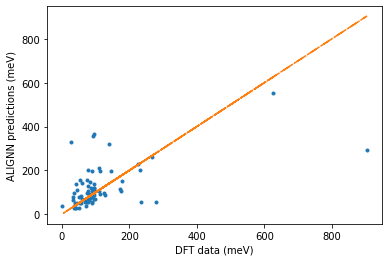

In [51]:
plt.plot(df['target'],df['prediction'],'.')
plt.plot(df['target'],df['target'],'-.')
plt.xlabel('DFT data (meV)')
plt.ylabel('ALIGNN predictions (meV)')

In [52]:
from jarvis.db.figshare import data as jdata
from jarvis.core.atoms import Atoms
import os

temp_dir_name = "DataDir_QM9_U0" 
os.makedirs(temp_dir_name)
os.chdir(temp_dir_name)

dft_3d = jdata("qm9_std_jctc") #jdata("dft_3d")
prop = "U0" #"exfoliation_energy" #"optb88vdw_bandgap"
f = open("id_prop.csv", "w")
# count = 0
for i in dft_3d:
    atoms = Atoms.from_dict(i["atoms"])
    jid = i["id"]
    poscar_name = "POSCAR-" + jid + ".vasp"
    target = i[prop]
    if target != "na":
        atoms.write_poscar(poscar_name)
        f.write("%s,%6f\n" % (poscar_name, target))
        # count += 1
        # if count == max_samples:
        #     break
f.close()

os.chdir(cwd)

Obtaining QM9 standardized dataset 130k,From https://doi.org/10.1021/acs.jctc.7b00577,+
Reference:https://www.nature.com/articles/sdata201422
Loading the zipfile...
Loading completed.


In [53]:
pwd

'/content/alignn'

In [54]:
!ls

alignn		    DataDir_QM9_U0  LICENSE.rst     README.md  temp
DataDir_ExfoEnergy  ExfoEnOut	    pyproject.toml  setup.py


Changing the cut-off in config_example.json as 5,  n_train as 110000, n_val as 10000, n_test as 10829

In [55]:
from jarvis.db.jsonutils import loadjson, dumpjson
config = loadjson("alignn/examples/sample_data/config_example.json")
config['cutoff'] = 5.0
config['n_train'] = 110000
config['n_val'] = 10000
config['n_test'] = 10829
dumpjson(data=config, filename="config_qm9.json")

Run for 1000 epochs instead of 5 here to get reasonable performance/MAE

In [ ]:
import time
t1=time.time()
!train_folder.py --root_dir "DataDir_QM9_U0" --epochs 5 --batch_size 64 --config "config_qm9.json" --output_dir="DataDir_QM9U0out"
t2=time.time()
print ('Time in s',t2-t1)

Using backend: pytorch
MAX val: 6.478244
MIN val: -3.583848
MAD: 0.78656595570948
Baseline MAE: 0.7850927436414451
data range 6.478244 -3.583848
  0% 0/110000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/jarvis/core/graphs.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  r = torch.tensor(r).type(torch.get_default_dtype())
  2% 2077/110000 [00:34<25:07, 71.59it/s]

In [56]:
!pip freeze

absl-py==1.0.0
alabaster==0.7.12
albumentations==0.1.12
alignn==2022.1.25
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.10
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.5.2
chardet==3.0.4
charset-normalizer==2.0.12
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda111==9.4.0
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.28
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
desc